In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Load and Understand Our Data

In [2]:
EPOCHS = 100
BATCH_SIZE = 32

In [3]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
print("X Train shape:", x_train.shape)
print(x_train[0][0][0])
print("Looks like we need to convert in between (0,1) by divide elements by 255 \n")
print("Y Train shape:", y_train.shape)
print(np.unique(y_train))
print("Looks like we have 10 unique classes for our data")

X Train shape: (50000, 32, 32, 3)
[59 62 63]
Looks like we need to convert in between (0,1) by divide elements by 255 

Y Train shape: (50000, 1)
[0 1 2 3 4 5 6 7 8 9]
Looks like we have 10 unique classes for our data


In [5]:
# Convert RGB to decimal in between [0,1] => 255 = 1, 0 = 0
x_train, x_test = x_train / 255.0, x_test / 255.0

# Flatten our target dataset
y_train, y_test = y_train.flatten(), y_test.flatten()
print("x_train.shape:", x_train.shape)
print("y_train.shape", y_train.shape)

x_train.shape: (50000, 32, 32, 3)
y_train.shape (50000,)


In [6]:
# Get number of target classes
k_class = len(np.unique(y_train))
print("Number of Classes:", k_class)

Number of Classes: 10


### Model

In [7]:
from tensorflow.keras import layers,models,optimizers
from tensorflow.keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [8]:
# Get input dimension
input_dimension = x_train[0].shape

# Input layer
inputs = Input(shape=input_dimension)
# Maxpooling layer
maxpool = MaxPooling2D((2,2))

# Convolution layers
x = Conv2D(32, (3,3), activation='relu')(inputs)
x = maxpool(x)
# x = Conv2D(32, (3,3), activation='relu')(inputs)
# x = maxpool(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = maxpool(x)
# x = Conv2D(64, (3,3), activation='relu')(x)
# x = maxpool(x)

x = Conv2D(128, (3,3), activation='relu')(x)
x = maxpool(x)

# Fully connected layer
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(k_class, activation='softmax')(x)

model = Model(inputs, x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   multiple             0           ['conv2d[0][0]',                 
                                                                  'conv2d_1[0][0]',               
                                                                  'conv2d_2[0][0]']               
                                                                                              

In [9]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    width_shift_range=0.1, 
                                    height_shift_range=0.1)

train_generator = data_generator.flow(x_train, y_train, BATCH_SIZE)

steps_per_epoch = x_train.shape[0] // BATCH_SIZE

fitted_model = model.fit(train_generator, 
                         validation_data=(x_test, y_test), 
                         steps_per_epoch=steps_per_epoch, 
                         epochs=EPOCHS)

Epoch 1/100
1562/1562 [==============================] - 39s 25ms/step - loss: 1.6879 - accuracy: 0.3732 - val_loss: 1.4833 - val_accuracy: 0.4560
Epoch 2/100
1562/1562 [==============================] - 39s 25ms/step - loss: 1.4010 - accuracy: 0.4930 - val_loss: 1.3419 - val_accuracy: 0.5197
Epoch 3/100
1562/1562 [==============================] - 39s 25ms/step - loss: 1.2710 - accuracy: 0.5457 - val_loss: 1.2168 - val_accuracy: 0.5627
Epoch 4/100
1562/1562 [==============================] - 39s 25ms/step - loss: 1.1925 - accuracy: 0.5738 - val_loss: 1.0949 - val_accuracy: 0.6054
Epoch 5/100
1562/1562 [==============================] - 39s 25ms/step - loss: 1.1387 - accuracy: 0.5947 - val_loss: 1.0749 - val_accuracy: 0.6217
Epoch 6/100
1562/1562 [==============================] - 38s 24ms/step - loss: 1.0894 - accuracy: 0.6100 - val_loss: 1.0437 - val_accuracy: 0.6297
Epoch 7/100
1562/1562 [==============================] - 38s 25ms/step - loss: 1.0506 - accuracy: 0.6263 - val_loss: 1

In [ ]:
def plot_acc_and_loss(acc, val_acc, loss, val_loss, epochs_range, condition):
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle("Model: Sparse Categorical Entropy Loss, Adam optimizer, 3 Layers")
    plt.savefig('./{}.png' .format(condition))
    plt.show()

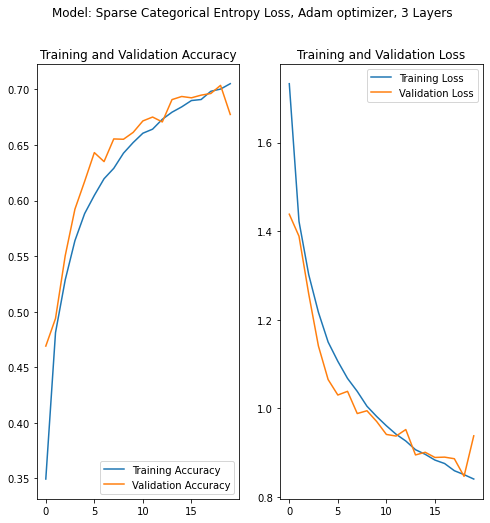

In [ ]:
epochs_range = range(EPOCHS)

acc = fitted_model.history['accuracy']
val_acc = fitted_model.history['val_accuracy']

loss = fitted_model.history['loss']
val_loss = fitted_model.history['val_loss']

plot_acc_and_loss(acc, val_acc, loss, val_loss, epochs_range, "Image Augmentation w/ 100 Epochs")

In [ ]:
avg_acc = np.mean(acc)
avg_val_acc = np.mean(val_acc)
print("Average Training accuracy: {:.2f}%".format(avg_acc*100))
print("Average Validation accuracy: {:.2f}%".format(avg_val_acc*100))

Average Training accuracy: 62.53%
Average Validation accuracy: 64.20%


In [19]:
model_no_augmentation = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20)

Epoch 1/20
1563/1563 [==============================] - 87s 56ms/step - loss: 0.4541 - accuracy: 0.8390 - val_loss: 0.7785 - val_accuracy: 0.7498
Epoch 2/20
1563/1563 [==============================] - 95s 61ms/step - loss: 0.3680 - accuracy: 0.8695 - val_loss: 0.8191 - val_accuracy: 0.7489
Epoch 3/20
1563/1563 [==============================] - 87s 56ms/step - loss: 0.2874 - accuracy: 0.8971 - val_loss: 0.8785 - val_accuracy: 0.7553
Epoch 4/20
1563/1563 [==============================] - 86s 55ms/step - loss: 0.2269 - accuracy: 0.9200 - val_loss: 0.9542 - val_accuracy: 0.7436
Epoch 5/20
1563/1563 [==============================] - 93s 60ms/step - loss: 0.1809 - accuracy: 0.9371 - val_loss: 1.0592 - val_accuracy: 0.7449
Epoch 6/20
1563/1563 [==============================] - 91s 58ms/step - loss: 0.1553 - accuracy: 0.9458 - val_loss: 1.1441 - val_accuracy: 0.7480
Epoch 7/20
1563/1563 [==============================] - 40s 26ms/step - loss: 0.1349 - accuracy: 0.9528 - val_loss: 1.2102 -

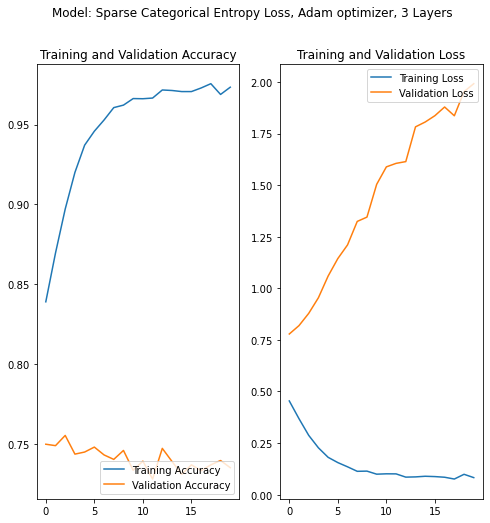

In [25]:
acc_1 = model_no_augmentation.history['accuracy']
val_acc_1 = model_no_augmentation.history['val_accuracy']

loss_1 = model_no_augmentation.history['loss']
val_loss_1 = model_no_augmentation.history['val_loss']

plot_acc_and_loss(acc_1, val_acc_1, loss_1, val_loss_1, epochs_range, "No Augmentation")

In [13]:
model.save_weights("model_adam.h5")